In [1]:
# 1번 블럭

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import Input, Flatten
from keras.layers import BatchNormalization, MaxPool2D
from keras.layers import Dense, Dropout
from keras.preprocessing.image import load_img

In [16]:
# 2번 블럭

MY_EPOCH = 200
MY_BATCH = 100
MY_RES = 180
MY_SHAPE = (MY_RES, MY_RES , 3)

# 모드 설정
DATA_MODE = 1
TRAIN_MODE = 1
MY_PATH = '/content/drive/MyDrive/dataset/container'

In [3]:
# 3번 블럭
# 변수 정의
# T_tot : train_tot, 학습용 이미지 갯수
# V_tot : validation total, 평가용 이미지 갯수
# N_tot : normal total, 정상 이미지 갯수
# P_tot : pnenmonia total, 손상 컨테이너 이미지 갯수
# N_path : normal image path, 정상 이미지 경로
# P_path : damaged image path, 손상컨테이너 이미지 경로

# 변수 초기화
T_tot = V_tot = N_tot = P_tot = 0
N_path = P_path = []

# 학습용 입력 데이터
X_train = np.zeros((0))

# 학습용 출력 데이터
Y_train = np.zeros((0))

# 평가용 입력 데이터
X_test = np.zeros((0))

# 평가용 출력 데이터
Y_test = np.zeros((0))

In [4]:
# 4번 블럭
# 학습용 이미지 경로 처리

def train_path():
  global T_tot, N_tot, P_tot, N_path, P_path

  # 정상 이미지 처리
  dir = os.path.join(MY_PATH,'n_con')
  print(dir)

  # 이미지 경로 모음
  N_path = []
  for f in sorted(os.listdir(dir)):
    N_path.append(os.path.join(dir, f))
  print('학습용 정상 이미지 갯수:', len(N_path))
  N_tot = len(N_path)

  # 손상된 이미지 처리
  dir = os.path.join(MY_PATH,'d_con')
  print(dir)

  # 이미지 경로 모음
  P_path = []
  for f in sorted(os.listdir(dir)):
    P_path.append(os.path.join(dir, f))
  print('학습용 손상된 이미지 갯수: ',len(P_path))
  P_tot = len(P_path)

  # 총 학습용 이미지 갯수
  T_tot = N_tot + P_tot
  print('총 학습용 이미지 갯수: ',T_tot)

train_path()

/content/drive/MyDrive/dataset/container/n_con
학습용 정상 이미지 갯수: 130
/content/drive/MyDrive/dataset/container/d_con
학습용 손상된 이미지 갯수:  188
총 학습용 이미지 갯수:  318


In [5]:
# 5번 블락
# 학습용 이미지 화소 통일

def train_resize():
  global T_tot, N_tot,P_tot,N_path,P_path
  global X_train, Y_train
  
  print('학습용 정상 이미지 처리 시작')
  begin = time()

  # 학습용 입력 데이터 4차원
  X_train = np.zeros((T_tot, MY_RES, MY_RES, 3))
  
  # 학습용 출력데이터는 1차원
  Y_train = np.zeros((T_tot, ))
  
  # 이미지 파일 하나씩 처리
  # 이미지 라벨: 0은 정상값, 1은 손상값
  for i, path in enumerate(N_path):
    # tmp = load_img(path)
    # print('원본 픽셀 수:',np.array(tmp).shape)
    # plt.imshow(tmp)
    # plt.show()

    img = load_img(path, target_size=(MY_RES, MY_RES))
    # print('처리 후 픽셀 수:',np.array(img).shape)
    # plt.imshow(img)
    # plt.show()
    # break

    X_train[i] = img
    Y_train[i] = 0
    
  end = time()
  print('학습용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  print('학습용 손상 이미지 처리 시작')
  begin = time()
  for i,path in enumerate(P_path):
    img = load_img(path, target_size=(MY_RES,MY_RES))
    X_train[i+ N_tot] = img
    Y_train[i+ N_tot] = 1
  end = time()
  print('학습용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  # 데이터 스케일링
  print('전',X_train[0].flatten())
  X_train =X_train / 255.0
  print('후',X_train[0].flatten())

In [6]:
# 6번 블럭 (4번 블럭과 흡사)
# 평가용 데이터 경로 처리

def test_path():
  global V_tot,N_tot,P_tot,N_path,P_path

  # 정상 이미지 처리
  dir = os.path.join(MY_PATH,'n_con')
  print(dir)

  # 정상 이미지 파일 경로 수집
  N_path = []
  for f in sorted(os.listdir(dir)):
    N_path.append(os.path.join(dir, f))
  print('평가용 정상 이미지 수', len(N_path))
  N_tot = len(N_path)

  # 손상 이미지 처리
  dir = os.path.join(MY_PATH,'d_con')
  print(dir)

  # 손상 이미지 파일 경로 수집
  P_path = []
  for f in sorted(os.listdir(dir)):
    P_path.append(os.path.join(dir, f))
  print('평가용 정상 이미지 수', len(P_path))
  P_tot = len(P_path)

  # 총 평가용 이미지 갯수
  V_tot = N_tot + P_tot
  print('총 평가용 이미지 갯수:', V_tot)

In [7]:
# 7번 블락 (5번 블락과 흡사)
# 평가용 이미지 화상도 통일 및 라벨 처리

def test_resize():
  global V_tot,N_tot,P_tot,N_path,P_path
  global X_test, Y_test

  print('평가용 정상 이미지 처리 시작')
  begin = time()

  X_test = np.zeros((V_tot, MY_RES, MY_RES, 3))
  Y_test = np.zeros((V_tot, ))

  for i, path in enumerate(N_path):
    img = load_img(path, target_size=(MY_RES, MY_RES))
    X_test[i] = img
    Y_test[i] = 0

  end = time()
  print('평가용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  print('평가용 손상된 이미지 처리 시작')
  begin = time()
  for i, path in enumerate(P_path):
    img = load_img(path, target_size=(MY_RES, MY_RES))
    X_test[i + N_tot] = img
    Y_test[i + N_tot] = 1

  end = time()
  print('평가용 손상된 이미지 처리 시간:{:.2f}'.format(end-begin))

  # 데이터 스케일링
  X_test = X_test / 255.0

In [8]:
# 8번 블럭
# 4분할 numpy 데이터 저장

def save_numpy():
  with open('container-array.npy','wb') as f:
    np.save(f, X_train)
    np.save(f, Y_train)
    np.save(f, X_test)
    np.save(f, Y_test)

  print('4분할 데이터 저장 완료')

In [9]:
# 9번 블럭
# 4분할 데이터 읽기

def load_numpy():
  global X_train,Y_train,X_test,Y_test

  with open('/content/drive/MyDrive/dataset/container-array.npy','rb') as f:
    X_train = np.load(f)
    Y_train = np.load(f)
    X_test = np.load(f)
    Y_test = np.load(f)
  
  print('4분할 데이터 읽기 완료')

In [10]:
# 10번 블럭
# 데이터 처리 컨트롤 타워

if DATA_MODE:
  train_path()
  train_resize()
  test_path()
  test_resize()
  save_numpy()
else:
  load_numpy()

/content/drive/MyDrive/dataset/container/n_con
학습용 정상 이미지 갯수: 130
/content/drive/MyDrive/dataset/container/d_con
학습용 손상된 이미지 갯수:  188
총 학습용 이미지 갯수:  318
학습용 정상 이미지 처리 시작


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


학습용 정상 이미지 처리 시간:66.98
학습용 손상 이미지 처리 시작
학습용 정상 이미지 처리 시간:90.10
전 [ 26.  21.  27. ... 140. 135. 141.]
후 [0.10196078 0.08235294 0.10588235 ... 0.54901961 0.52941176 0.55294118]
/content/drive/MyDrive/dataset/container/n_con
평가용 정상 이미지 수 130
/content/drive/MyDrive/dataset/container/d_con
평가용 정상 이미지 수 188
총 평가용 이미지 갯수: 318
평가용 정상 이미지 처리 시작
평가용 정상 이미지 처리 시간:1.84
평가용 손상된 이미지 처리 시작
평가용 손상된 이미지 처리 시간:0.82
4분할 데이터 저장 완료


In [11]:
# 11번 블럭
# 데이터 모양 확인

print('학습용 입력 데이터: ',X_train.shape)
print('학습용 출력 데이터: ',Y_train.shape)
print('평가용 입력 데이터: ',X_test.shape)
print('평가용 출력 데이터: ',Y_test.shape)

학습용 입력 데이터:  (318, 180, 180, 3)
학습용 출력 데이터:  (318,)
평가용 입력 데이터:  (318, 180, 180, 3)
평가용 출력 데이터:  (318,)


[73, 111, 86, 30, 10, 157, 190, 126, 257, 35, 57, 18, 162, 239, 282, 181]


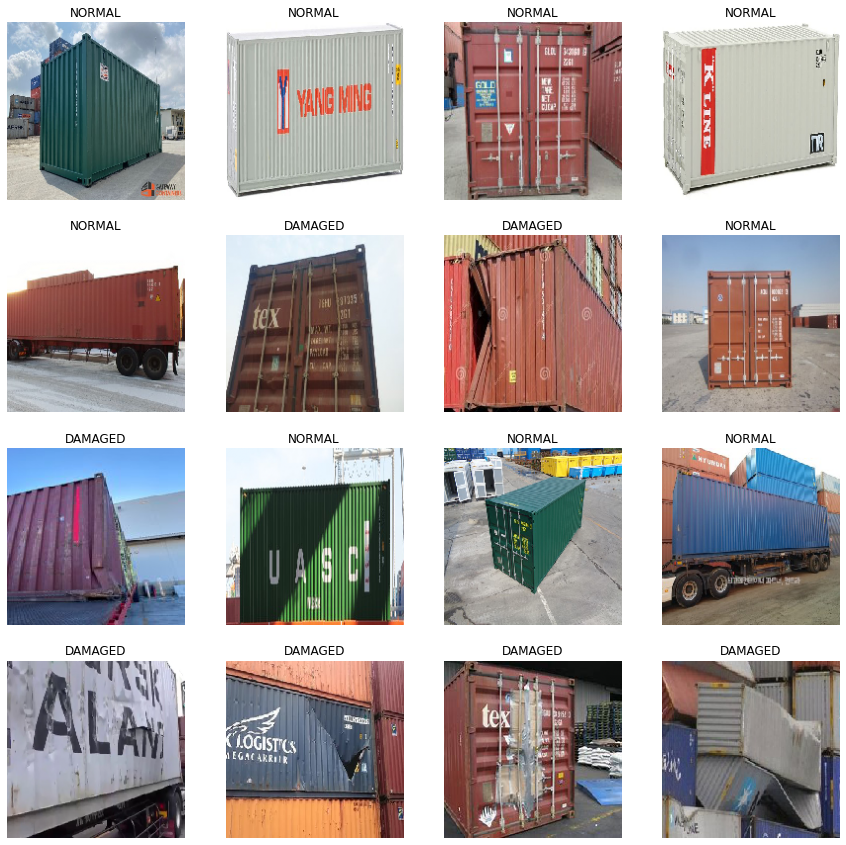

In [12]:
# 12번 블럭
# 샘플 이미지 16을 4x4 프레임으로  출력 후 파일로 저장
# X_train에서 (학습용 입력 이미지에서 16개 무작위로 추출)

total =  len(X_train)
pick = random.sample(range(0,total),16)
print(pick)

fig, spot = plt.subplots(4, 4, figsize=(15,15))
cnt = 0

for i in range(4):
  for j in range(4):
    spot[i,j].imshow(X_train[pick[cnt]])

    #라벨 정보 추가
    label = Y_train[pick[cnt]]
    if label:
      spot[i,j].title.set_text('DAMAGED')
    else:
      spot[i,j].title.set_text('NORMAL')
    spot[i,j].axis('off')
    cnt += 1

plt.savefig('sample.png')

In [13]:
# 13번 블럭
# 합성곱 블락

def conv_block(filters, inputs):
  x = SeparableConv2D(filters=filters,
                      kernel_size = 3,
                      activation = 'relu',
                      padding = 'same')(inputs)
  x = SeparableConv2D(filters=filters,
                      kernel_size = 3,
                      activation = 'relu',
                      padding = 'same')(x)

  x = BatchNormalization()(x)

  output = MaxPool2D(pool_size=2)(x)

  return output

In [14]:
# 14번 블럭
# dense 블럭 구현

def dense_block(units, drop, inputs):
  x = Dense(units=units,
            activation = 'relu')(inputs)
  
  x = BatchNormalization()(x)
  output = Dropout(drop)(x)

  return output

In [15]:
# 15번 블럭
# 전체 CNN 구성

# 1번 층: 입력층
my_input = Input(shape=(MY_SHAPE))

# 2번 층
x = Conv2D(filters=16,
           kernel_size = 3,
           activation='relu',
           padding='same')(my_input)

x = Conv2D(filters=16,
           kernel_size = 3,
           activation='relu',
           padding='same')(x)

x = MaxPool2D(pool_size=2)(x)

# 3번 블럭
x = conv_block(32,x)

# 4번 블럭
x = conv_block(64,x)

# 5번 블럭
x = conv_block(128,x)
x = Dropout(0.2)(x)

# 6번 블럭
x = conv_block(256,x)
x = Dropout(0.2)(x)

# 7번 블럭
x= Flatten()(x)

# 8번 블럭
x = dense_block(512, 0.7, x)
x = dense_block(128, 0.5, x)
x = dense_block(64, 0.3, x)

# 9번 블럭
my_output = Dense(units=1,
            activation = 'sigmoid')(x)

# 모델 만들고 요약
model = Model(inputs=my_input,
              outputs = my_output)

print('CNN 요약')
model.summary()

CNN 요약
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)       

In [17]:
# 16번 블럭
# CNN 학습 환경 설정

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=['acc'])
# 학습 모드 구현
if TRAIN_MODE:

  # 학습 진행
  begin = time()
  print('학습 시작')

  model.fit(x = X_train,
            y= Y_train,
            epochs=MY_EPOCH,
            batch_size=MY_BATCH,
            verbose=1)

  end = time()
  print('총 학습 시간: {: .2f}'.format(end-begin))
  model.save_weights('damaged.h5')
else:
  model.load_weights('damaged.h5')

학습 시작
Epoch 1/200
4/4 [==============================] - 34s 627ms/step - loss: 0.9724 - acc: 0.4811
Epoch 2/200
4/4 [==============================] - 2s 368ms/step - loss: 0.8080 - acc: 0.5660
Epoch 3/200
4/4 [==============================] - 2s 370ms/step - loss: 0.8379 - acc: 0.5629
Epoch 4/200
4/4 [==============================] - 2s 372ms/step - loss: 0.8247 - acc: 0.5723
Epoch 5/200
4/4 [==============================] - 2s 376ms/step - loss: 0.8105 - acc: 0.5881
Epoch 6/200
4/4 [==============================] - 2s 373ms/step - loss: 0.7657 - acc: 0.5786
Epoch 7/200
4/4 [==============================] - 2s 376ms/step - loss: 0.7528 - acc: 0.5818
Epoch 8/200
4/4 [==============================] - 2s 373ms/step - loss: 0.8091 - acc: 0.5912
Epoch 9/200
4/4 [==============================] - 2s 383ms/step - loss: 0.7863 - acc: 0.6164
Epoch 10/200
4/4 [==============================] - 2s 371ms/step - loss: 0.8109 - acc: 0.5912
Epoch 11/200
4/4 [==============================] - 

In [18]:
# 17번 블럭
# CNN 평가

score = model.evaluate(x=X_test,
                       y=Y_test,
                       verbose=1)

print('최종 손실값:{: .2f}'.format(score[0]))
print('최종 정확도:{: .2f}'.format(score[1]))

10/10 [==============================] - 2s 79ms/step - loss: 0.9523 - acc: 0.7107
최종 손실값: 0.95
최종 정확도: 0.71


[136] 번 사진
정답: [1.]
예측 [[0.9996376]]


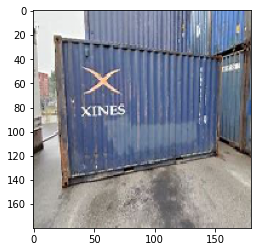

In [23]:
# 18번 블럭

total = len(X_test)
pick = random.sample(range(0,total), 1)
print(pick,'번 사진')

plt.imshow(X_test[pick].reshape(MY_RES,MY_RES,3))

img = X_test[pick].reshape(1,MY_RES,MY_RES,3)
pred = model.predict(img)

print('정답:',Y_test[pick])
print('예측',pred)